In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False

class DogVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    
    LABELS = {CATS : 0, DOGS: 1}
    training_data = []
    
    catCount = 0
    dogCount = 0
    
    def make_training_data(self):
        for label in tqdm(self.LABELS):
            for f in os.listdir(label):
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catCount += 1
                    elif label == self.DOGS:
                        self.dogCount += 1
                except Exception as e:
                    print(f)
                    
                    
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.catCount)
        print("Dogs: ", self.dogCount)
        
if REBUILD_DATA:
    dogs_v_cats = DogVSCats()
    dogs_v_cats.make_training_data()

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

10125.jpg
10404.jpg
10501.jpg
10820.jpg
11210.jpg
11565.jpg
11874.jpg
11935.jpg
140.jpg
2663.jpg
3300.jpg
3491.jpg
4833.jpg
5553.jpg
660.jpg
666.jpg
7968.jpg
7978.jpg
8470.jpg
850.jpg
9171.jpg
936.jpg
9565.jpg
9778.jpg


 50%|██████████████████████████████████████████                                          | 1/2 [00:27<00:27, 27.71s/it]

Thumbs.db
10158.jpg
10401.jpg
10747.jpg
10797.jpg
11410.jpg
11675.jpg
11702.jpg
11849.jpg
11853.jpg
1308.jpg
1866.jpg
2384.jpg
2688.jpg
2877.jpg
3136.jpg
3288.jpg
3588.jpg
4367.jpg
5604.jpg
5736.jpg
6059.jpg
6238.jpg
6718.jpg
7112.jpg
7133.jpg
7369.jpg
7459.jpg
7969.jpg
8730.jpg
9188.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:16<00:00, 38.41s/it]

Thumbs.db



d:\my docs\university\applied data science\project\simple_neural_network\venv\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Cats:  12469
Dogs:  12470


In [2]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [3]:
print(len(training_data))

24939


In [6]:
print(training_data[0])

[array([[ 61,  65,  72, ...,  32,  39,  59],
        [ 67,  57,  38, ..., 110, 116, 115],
        [ 37,  34,  36, ..., 128,  98, 102],
        ...,
        [ 48,  93, 123, ...,  72,  85,  92],
        [ 27,  29,  52, ...,  62,  82,  91],
        [ 38,  46,  47, ...,  72,  81,  84]], dtype=uint8) array([0., 1.])]


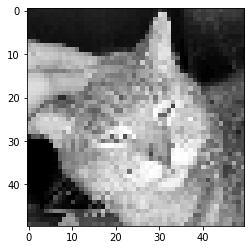

In [10]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap = "gray")
plt.show()

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1 ,   32, 5)
        self.conv2 = nn.Conv2d(32 ,  64, 5)
        self.conv3 = nn.Conv2d(64 , 128, 5)
        
        x = torch.randn(50,50).view(-1, 1 , 50 , 50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        if self._to_linear is None:
            s = x[0].shape
            self._to_linear = s[0] * s[1] * s[2]
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.softmax(x, dim = 1)

In [19]:
net = Net()

In [20]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)

loss_function = nn.MSELoss()
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2493


In [21]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X) , len(test_X))

22446 2493


In [28]:
BATCH_SIZE = 100
EPOCHS = 3

for epoch in range(EPOCHS):
    for i in tqdm(range(0,len(train_X) , BATCH_SIZE)):
        batch_X = train_X[i : i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i : i+BATCH_SIZE]
        
        optimizer.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
print(loss)

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [01:27<00:00,  2.56it/s]

tensor(0.1014, grad_fn=<MseLossBackward>)


In [29]:
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
        
print("Accuracy:", round(correct/total, 3))

100%|█████████████████████████████████████████████████████████████████████████████| 2493/2493 [00:07<00:00, 336.11it/s]

Accuracy: 0.755


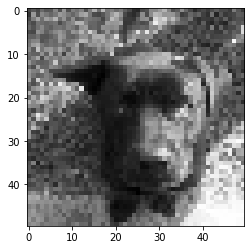

tensor([[[[0.2941, 0.3333, 0.4471,  ..., 0.2392, 0.2196, 0.1725],
          [0.3137, 0.3412, 0.4549,  ..., 0.2157, 0.1922, 0.1765],
          [0.3451, 0.3647, 0.4275,  ..., 0.2157, 0.2039, 0.1882],
          ...,
          [0.7765, 0.7804, 0.8078,  ..., 0.1569, 0.1608, 0.1490],
          [0.7176, 0.7647, 0.8196,  ..., 0.1569, 0.1490, 0.1373],
          [0.7137, 0.7294, 0.7451,  ..., 0.1569, 0.1412, 0.1137]]]])
tensor([[[[ 85, 102,  86,  ..., 132,  99,  75],
          [ 70, 160,  92,  ...,  86, 104, 101],
          [ 90, 135, 169,  ...,  87,  94,  92],
          ...,
          [151, 158, 149,  ..., 252, 252, 252],
          [160, 133, 158,  ..., 252, 249, 248],
          [144, 154, 145,  ..., 252, 248, 249]]]], dtype=torch.uint8)


In [51]:
import matplotlib.pyplot as plt
img = training_data[199][0]
plt.imshow(img, cmap = "gray")
plt.show()
print(test_X[11].view(-1,1,50,50))
print(torch.tensor(img).view(-1,1,50,50))

img = (torch.tensor(img)/255).view(-1,1,50,50)

In [52]:
net(img)

tensor([[0.0844, 0.9156]], grad_fn=<SoftmaxBackward>)